# FCN #

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from pycocotools.coco import COCO
from pycocotools.mask import decode

# Define paths
train_data_path = '/content/drive/MyDrive/Minor 2/mrcnn/seg_with_mrcnn/dataset/train'
train_annot_path = os.path.join(train_data_path, '_annotations.coco.json')

test_data_path = '/content/drive/MyDrive/Minor 2/mrcnn/seg_with_mrcnn/dataset/test'
test_annot_path = os.path.join(test_data_path, '_annotations.coco.json')

val_data_path = '/content/drive/MyDrive/Minor 2/mrcnn/seg_with_mrcnn/dataset/valid'
val_annot_path = os.path.join(val_data_path, '_annotations.coco.json')


In [3]:
def load_and_preprocess_data(data_path, annot_path, target_size=(256, 256)):
    coco = COCO(annot_path)
    image_ids = coco.getImgIds()
    images = []
    masks = []

    for image_id in image_ids:
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(data_path, img_info['file_name'])
        image = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0

        ann_ids = coco.getAnnIds(imgIds=img_info['id'])
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros(target_size, dtype=np.uint8)
        for ann in anns:
            rle = coco.annToRLE(ann)
            ann_mask = decode(rle)
            ann_mask = tf.image.resize(tf.expand_dims(ann_mask, axis=-1), target_size, method='nearest')
            ann_mask = tf.squeeze(ann_mask).numpy().astype(np.uint8)
            mask += ann_mask

        mask = np.clip(mask, 0, 1)  # Ensure the mask is binary (0 or 1)

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

train_images, train_masks = load_and_preprocess_data(train_data_path, train_annot_path)
val_images, val_masks = load_and_preprocess_data(val_data_path, val_annot_path)
test_images, test_masks = load_and_preprocess_data(test_data_path, test_annot_path)


loading annotations into memory...
Done (t=8.00s)
creating index...
index created!
loading annotations into memory...
Done (t=1.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [4]:
def build_fcn_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = Conv2DTranspose(21, kernel_size=(64, 64), strides=(32, 32), padding='same', activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

input_shape = (256, 256, 3)
model = build_fcn_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [5]:
def data_generator(images, masks, batch_size=8):
    while True:
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            image_batch = images[start:end]
            mask_batch = masks[start:end]
            yield image_batch, mask_batch

batch_size = 8
train_generator = data_generator(train_images, train_masks, batch_size)
val_generator = data_generator(val_images, val_masks, batch_size)


In [6]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_images)//batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=len(val_images)//batch_size)

# Extracting training history
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

# Save training history to CSV
history_csv_file = '/content/training_history.csv'
history_df.to_csv(history_csv_file, index=False)


Epoch 1/100
155/155 [==============================] - 736s 521ms/step - loss: 5.8691 - accuracy: 0.6883 - val_loss: 0.5734 - val_accuracy: 0.7086
Epoch 2/100
155/155 [==============================] - 802s 3s/step - loss: 0.5347 - accuracy: 0.7337 - val_loss: 0.6426 - val_accuracy: 0.6868
Epoch 3/100
155/155 [==============================] - 80s 517ms/step - loss: 0.5223 - accuracy: 0.7425 - val_loss: 0.5814 - val_accuracy: 0.7060
Epoch 4/100
155/155 [==============================] - 80s 517ms/step - loss: 0.5203 - accuracy: 0.7457 - val_loss: 0.5428 - val_accuracy: 0.7379
Epoch 5/100
155/155 [==============================] - 80s 517ms/step - loss: 0.5076 - accuracy: 0.7516 - val_loss: 0.5238 - val_accuracy: 0.7456
Epoch 6/100
155/155 [==============================] - 80s 517ms/step - loss: 0.5033 - accuracy: 0.7530 - val_loss: 0.5197 - val_accuracy: 0.7427
Epoch 7/100
155/155 [==============================] - 80s 517ms/step - loss: 0.4901 - accuracy: 0.7605 - val_loss: 0.5071 - 

In [7]:
from tensorflow.keras.metrics import MeanIoU

def evaluate_model(model, images, masks, num_classes):
    iou_metric = MeanIoU(num_classes=num_classes)
    for img, mask in zip(images, masks):
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        pred_mask = model.predict(img)
        pred_mask = np.argmax(pred_mask, axis=-1)
        pred_mask = np.squeeze(pred_mask)
        iou_metric.update_state(mask, pred_mask)
    return iou_metric.result().numpy()

test_iou = evaluate_model(model, test_images, test_masks, num_classes=21)
print(f"Test IoU: {test_iou}")

1/1 [==============================] - 0s 21ms/step
Test IoU: 0.8083518147468567


In [8]:
model.save('/content/Fcn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


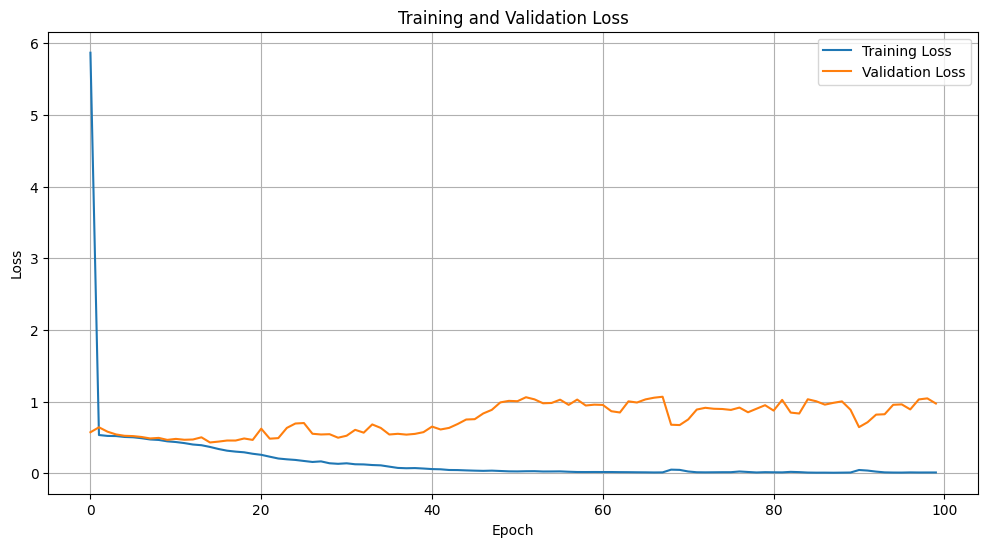

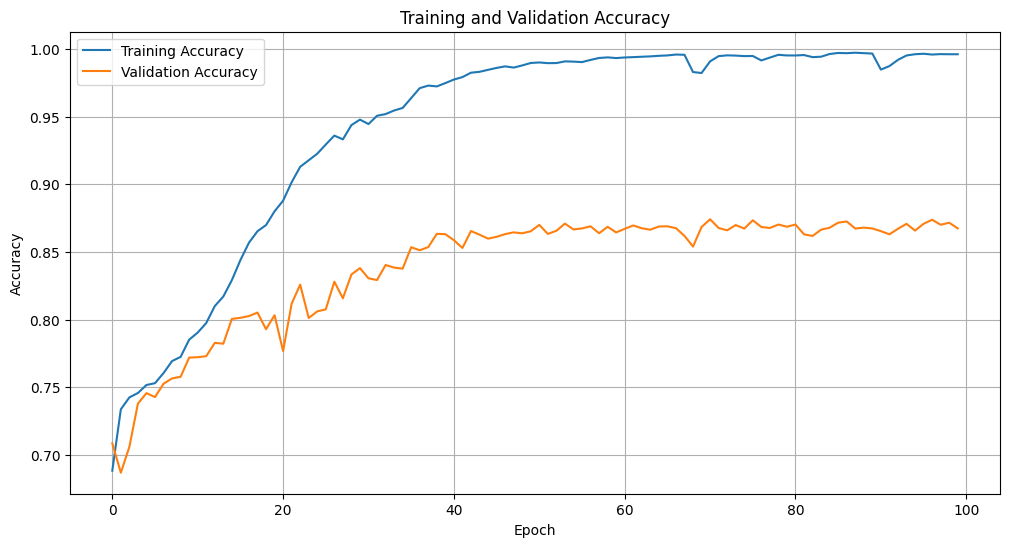

In [9]:
import matplotlib.pyplot as plt

# Load the saved training history from CSV
history_df = pd.read_csv(history_csv_file)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_df['epoch'], history_df['loss'], label='Training Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_df['epoch'], history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['epoch'], history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
